# Dereddening a spectrum and calculating reddening

Kristen Larson (@krislars) with ideas from Emir Karamehmetoglu (@emirkmo)

June 2018

## Learning Goals
- Investigate extinction curve shapes
- Redden and deredden spectra
- Calculate photometric extinction and reddening
- Use `dust_extinction` and `synphot` together





## Keywords
`dust_extinction`,  `synphot`

# Introduction

Dust in the interstellar medium (ISM) extinguishes background starlight.  The wavelength dependence of the extinction is such that short-wavelength light is extinguished more than long-wavelength light, and we call this effect *reddening*.

If you're new to extinction, here is a brief introduction to the types of quantities involved.
The fractional change to the flux of starlight is 
$$
\frac{dF_\lambda}{F_\lambda} = -\tau_\lambda
$$
where $\tau$ is the optical depth.  This means that resultant flux must be an exponential function of optical depth,
$$
\tau_\lambda = -\ln\left(\frac{F_\lambda}{F_{\lambda,0}}\right).
$$

We usually changes bases from $e$ to 10,  
$$
\tau_\lambda = -2.303\log\left(\frac{F_\lambda}{F_{\lambda,0}}\right),
$$
and given how we define magnitudes, it is convenient to define an extinction $A_\lambda = 1.086 \,\tau_\lambda$ so that
$$
A_\lambda = -2.5\log\left(\frac{F_\lambda}{F_{\lambda,0}}\right).
$$


So, what is our point here?  There are two basic take-home messages:

* Extinction introduces a multiplying factor $10^{-0.4 A_\lambda}$ to the flux.
* Extinction is defined relative to the flux without dust $F_{\lambda,0}$.

In this tutorial, we will look at some extinction curves from the literature, use one of those curves to deredden an observed spectrum, and practice invoking a background source flux in order to calculate magnitudes from an extinction model.

## Installation

In [1]:
# For running in Google Colaboratory:
# !pip install astropy
# !pip install dust_extinction
# !pip install synphot

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import astropy.units as u
from astropy.table import Table
from dust_extinction.dust_extinction import CCM89, F99

In [3]:
from synphot import units
from synphot import SourceSpectrum,SpectralElement,Observation,ExtinctionModel1D
from synphot.models import BlackBodyNorm1D
from synphot.spectrum import BaseUnitlessSpectrum
from synphot.reddening import ExtinctionCurve

# Example 1: Investigate Extinction Models

The `dust_extinction` package provides various models for normalized extinction $A_\lambda$.  The shape of normalized curves is relatively (and perhaps surprisingly) uniform in the Milky Way.  Variation in the normalized extinction curve due to environmental conditions is often parameterized by the ratio of extinction to reddening,
$$
R_V = \frac{A_V}{E_{B-V}}
$$
where reddening $E_{B-V}$ is differential extinction $A_B-A_V$.  In this example, we show that parameterization for the Clayton, Cardelli, & Mathis (1989, CCM) and the Fitzpatrick (1999) models.

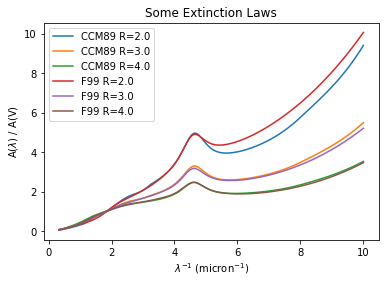

In [4]:
# Create wavelengths array.
wav = np.arange(0.1, 3, 0.001)*u.micron

for model in [CCM89,F99]:
    for R in (2.0,3.0,4.0):
      # Initialize the extinction model.
      ext = model(Rv=R)
      plt.plot(1/wav, ext(wav), label=model.name+' R='+str(R))

plt.xlabel('$\lambda^{-1}$ (micron$^{-1}$)')
plt.ylabel('A($\lambda$) / A(V)')
plt.legend(loc='best')
plt.title('Some Extinction Laws')
plt.show()

ISM astronomers often display extinction curves against inverse wavelength (wavenumber) to show the ultraviolet variation.  Infrared extinction varies less, and approaches zero in the absence of grey (wavelength-indendent) extinction.

# Example 2: Deredden a Spectrum

Here we deredden (unextinguish) the IUE ultraviolet spectrum of the star $\rho$ Oph. 

First, we fetch the spectrum from the IUE archive and read the data into an astropy table.

In [5]:
x1,y1 = np.loadtxt(
    'http://archive.stsci.edu/missions/iue/previews/mx/lwr/05000/gz/lr05639.gz',
    unpack=True,skiprows=20,usecols=(0,1))

x2,y2 = np.loadtxt(
    'http://archive.stsci.edu/missions/iue/previews/mx/swp/06000/gz/sp06588.gz',
    unpack=True,skiprows=20,usecols=(0,1))

rhoOph = Table()
rhoOph['wav'] = np.append(x2,x1)*u.AA
rhoOph['flux'] = np.append(y2,y1)*u.erg/(u.cm*u.cm*u.s*u.AA)

Then, we initialize the extinction model, choosing a value for $R_V$ and reddening $E_{B-V}$.

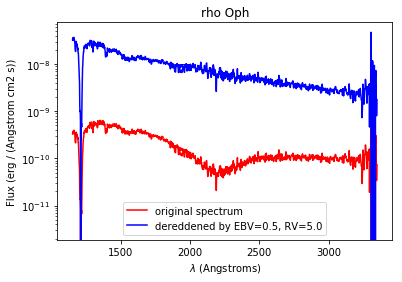

In [6]:
# Choose values here.
Rv = 5.0
Ebv = 0.5
ext = F99(Rv=Rv)

# Now we call the ext.extinguish method, which returns the extinction factor.
rhoOph['extcorr'] = rhoOph['flux']/ext.extinguish(rhoOph['wav'], Ebv=Ebv)
# If we wanted to extinguish a flux, we would multiply instead of divide.

plt.semilogy(rhoOph['wav'],rhoOph['flux'],'r',label='original spectrum')
plt.semilogy(rhoOph['wav'],rhoOph['extcorr'],'b',
             label='dereddened by EBV='+str(Ebv)+', RV='+str(Rv))
plt.legend(loc='best')
plt.title('rho Oph')
plt.xlabel('$\lambda$ (Angstroms)')
plt.ylabel('Flux ('+str(rhoOph['flux'].unit)+')')
plt.show()

Notice that the absorption feature at 2175 Angstrom is removed.  This feature can also be seen as the prominent bump in the extinction curves in Example 1.

Those experienced with dereddening should notice that that `dust_extinction` returns $A_\lambda/A_V$, while other routines like the IDL `fm_unred` procedure often return $A_\lambda/E_{B-V}$ by default and must be divided by $R_V$ to compare directly.

# Example 3: Calculate Color Excess with `synphot`

Calculating broadband *photometric* extinction is harder than it might look at first.  All we have to do is look up $A_\lambda$ for a particular band, right?  Under the right conditions, yes.  In general, no.

Remember that we have to integrate over a passband to get synthetic photometry,
$$
A = -2.5\log\left(\frac{\int W_\lambda F_{\lambda,0} 10^{-0.4A_\lambda} d\lambda}{\int W_\lambda F_{\lambda,0} d\lambda} \right),
$$
where $W_\lambda$ is the fraction of incident energy transmitted through a filter.  See the detailed appendix in Bessell & Murphy (2012) for an excellent review of the issues and variables used in synthetic photometry.

There is an important point to be made here. The expression above does not simplify any further. Strictly speaking, it is impossible to correctly calculate magnitude extinction without the original flux, even if you know the extinction curve. Only if the flux is constant in the band (i.e. $F_\lambda = F$) can we cancel these factors out from the integrals and directly convert an extinction model into magnitudes.  In this example, we will use a blackbody curve for the flux before the dust.

First, let's get the filter transmission curves:

In [7]:
u_band = SpectralElement.from_filter('johnson_u')
b_band = SpectralElement.from_filter('johnson_b')
v_band = SpectralElement.from_filter('johnson_v')
r_band = SpectralElement.from_filter('johnson_r')
i_band = SpectralElement.from_filter('johnson_i')
j_band = SpectralElement.from_filter('bessel_j')
h_band = SpectralElement.from_filter('bessel_h')
k_band = SpectralElement.from_filter('bessel_k')

The lines above get the filter transmission curves from an FTP server at STScI.  If they don't work, you can try this instead:

~~~~
from synphot import config
config.conf.vega_file='http://ssb.stsci.edu/cdbs/calspec/alpha_lyr_stis_008.fits'
config.conf.johnson_u_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_u_004_syn.fits'
~~~~

and so on for the rest of the filters you want.  If you are running this with your own python, see the [synphot documentation](https://synphot.readthedocs.io/en/latest/#installation-and-setup) on how to download your own copy of the necessary files.

Next, let's make a background flux to which we will apply extinction.  Here we make a 10,000 K blackbody using the model mechanism from within `synphot` and normalize it to $V$ = 10 in the Vega-based magnitude system.

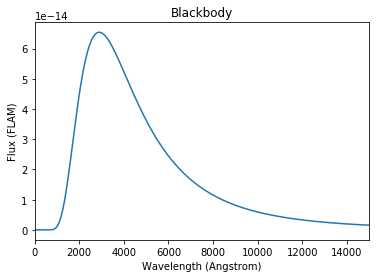

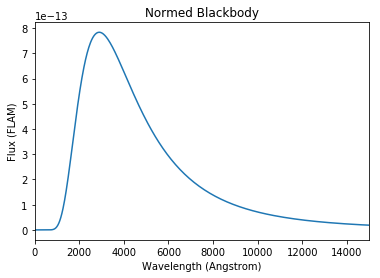

In [8]:
# First, create a blackbody at some temperature.
sp = SourceSpectrum(BlackBodyNorm1D, temperature=10000)
sp.plot(left=1, right=15000, flux_unit='flam', title='Blackbody')

# Get the Vega spectrum as the zero point flux.
vega = SourceSpectrum.from_vega()
# vega.plot(left=1, right=15000)

# Normalize the blackbody to some chosen magnitude, say V = 10.
vmag = 10.
v_band = SpectralElement.from_filter('johnson_v')
sp_norm = sp.normalize(vmag * units.VEGAMAG, v_band, vegaspec=vega)
sp_norm.plot(left=1, right=15000, flux_unit='flam', title='Normed Blackbody')

Now we initialize the extinction model and choose an extinction of $A_V = 2$.  To get the `dust_extinction` model working with `synphot`, we create a wavelength array and make a spectral element with the extinction model as a lookup table.

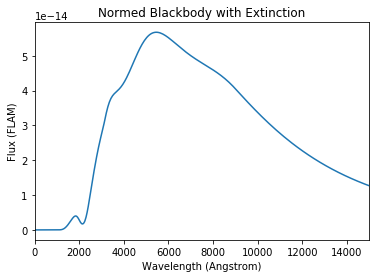

In [9]:
# Initialize the extinction model and choose the extinction, here Av = 2.
ext = CCM89(Rv=3.1)
Av = 2.

# Create a wavelength array. 
wav = np.arange(0.1, 3, 0.001)*u.micron

# Make the extinction model in synphot using a lookup table.
ex = ExtinctionCurve(ExtinctionModel1D, 
                     points=wav, lookup_table=ext.extinguish(wav, Av=Av))
sp_ext = sp_norm*ex
sp_ext.plot(left=1, right=15000, flux_unit='flam',
            title='Normed Blackbody with Extinction')

Synthetic photometry means sending the astronomical flux through a certain filter...

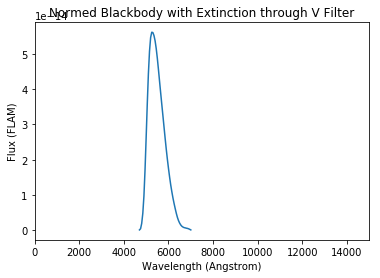

In [10]:
# "Observe" the star through the filter and integrate to get photometric mag.
sp_obs = Observation(sp_ext, v_band)
sp_obs_before = Observation(sp_norm, v_band)
sp_obs.plot(left=1, right=15000, flux_unit='flam',
            title='Normed Blackbody with Extinction through V Filter')

...and integrating it to get a flux.  The "effective stimulus" in `synphot` refers to the integrated flux that would be incident on a detector.  Invoking the Vega flux unit will convert the flux to a Vega-based magnitude system. 

In [11]:
sp_stim_before = sp_obs_before.effstim(flux_unit='vegamag', vegaspec=vega)
sp_stim = sp_obs.effstim(flux_unit='vegamag', vegaspec=vega)
print('before dust, V =', np.round(sp_stim_before,1))
print('after dust, V =', np.round(sp_stim,1))

# Calculate extinction and compare to our chosen value.
Av_calc = sp_stim - sp_stim_before
print('$A_V$ = ', np.round(Av_calc,1))

before dust, V = 10.0 VEGAMAG
after dust, V = 12.0 VEGAMAG
$A_V$ =  2.0 VEGAMAG


Ah, good!  We normalized our spectrum to $V$ = 10 mag and added 2 mag of visual extinction, and our synthetic photometry reproduces these chosen values.  We're feeling ready to find the extinction in other passbands. 

We calculate the new photometry for the rest of the Johnson optical and the Bessell infrared filters. We calculate extinction $A = \Delta m$ and plot color excess, $E(\lambda - V) = A_\lambda - A_V$.  

Notice that `synphot` calculates the effective wavelength of the observations for us.  Handy for plotting!

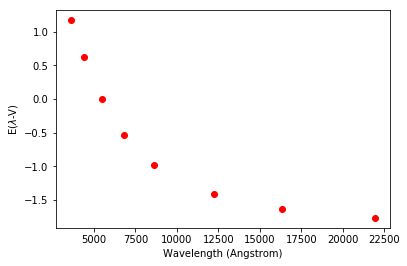

In [12]:
bands = [u_band,b_band,v_band,r_band,i_band,j_band,h_band,k_band]

for band in bands:
    # Calculate photometry with dust:
    sp_obs = Observation(sp_ext, band)
    obs_effstim = sp_obs.effstim(flux_unit='vegamag', vegaspec=vega)
    # Calculate photometry without dust:
    sp_obs_i = Observation(sp_norm, band)
    obs_i_effstim = sp_obs_i.effstim(flux_unit='vegamag', vegaspec=vega)
  
    # Extinction = mag with dust - mag without dust
    # Color excess = extinction at lambda - extinction at V
    color_excess = obs_effstim - obs_i_effstim - Av_calc
    plt.plot(sp_obs_i.effective_wavelength(), color_excess,'or')

plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('E($\lambda$-V)')
plt.show()  

## Exercise
Try changing the blackbody temperature to something very hot or very cool.  Do you get the same thing?  

The extinction changes because the filter transmission is not uniform, so the throughput of the filter depends on the shape of the background source flux.